In [114]:
import numpy as np

# cf. TI SPRA 291
# random 2N-point real sequence
g = np.random.randn(16)

# size of sequence
n = len(g)//2
n2 = 2 * n

# form a N-point complex sequence and its DFT
x = g[::2] + 1j*g[1::2]
X = np.fft.fft(x)

# retain x0 for idft
X0 = X[0]

# some helper terms
W = lambda k, N: np.exp(-2j*np.pi*k/N)
A = lambda k: 0.5*(1 - 1j*W(k,n2))
B = lambda k: 0.5*(1 + 1j*W(k,n2))

# form the positive part of the DFT for the 2N-point real sequence
k = np.r_[:n]
G1 = X*A(k) + np.conj(X)[np.r_[0,n-k[1:]]]*B(k)
# G1[0] = X0

# check it's correct
G2 = np.fft.fft(g)[np.fft.fftfreq(n2)>=0]
np.testing.assert_allclose(G1, G2)

# # back the other way w/ same fft func
k1 = np.r_[0,n-k[1:]]
X1 = G2*np.conj(A(k)) + np.conj(G2)[k1]*np.conj(B(k))
# X1[0] = 0
x1 = np.conj(np.fft.fft(np.conj(X1)))/n
g1 = np.c_[x1.real, x1.imag].flat[:]
# np.testing.assert_allclose(g1, g)

In [115]:
G3 = np.fft.fft(g)
# G3[0] += 50
# G3[0] = 0
g3 = np.fft.ifft(G3)
np.fft.fftfreq(g.size)

array([ 0.    ,  0.0625,  0.125 ,  0.1875,  0.25  ,  0.3125,  0.375 ,
        0.4375, -0.5   , -0.4375, -0.375 , -0.3125, -0.25  , -0.1875,
       -0.125 , -0.0625])

Populating the interactive namespace from numpy and matplotlib


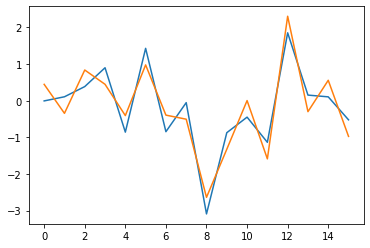

In [117]:
%pylab inline
# plot(g)
plot(g1)
plot(g3.real)

For our purposes, this could work: the m=0 is scaled by `D*l*(l+1)` effectively zero. Or at least the impact on the simualtion is small because it represents the dc shift of the field, which the local connectivity has no effect on.  It seems to smooth it a bit anyhow.  Let's move forward from this to a full sht kernel.

In [55]:
A(0)*X0, B(0)*np.conj(X0), G1[0], X0

((-1.1740247114743287-2.34198404185332j),
 (-1.1740247114743287+2.34198404185332j),
 (-2.3480494229486575+0j),
 (1.167959330378991-3.5160087533276485j))

In [9]:
G2[0]*A(0) + G2[0]*B(0), X[0], A(0), B(0)

((-2.5268328336737396+0j),
 (0.22416463741117254-2.750997471084912j),
 (0.5-0.5j),
 (0.5+0.5j))

In [19]:
np.fft.fft(np.r_[3+-0.5j,0,0,0])

array([3.-0.5j, 3.-0.5j, 3.-0.5j, 3.-0.5j])

Generate A and B real and imag parts,

In [119]:
import sympy as sp
k,N=sp.Symbol('k',real=True),sp.Symbol('N',real=True)
A = (1-sp.I*sp.exp(-2*sp.I*sp.pi*k/N))/2
B = (1+sp.I*sp.exp(-2*sp.I*sp.pi*k/N))/2


In [120]:
sp.re(A), sp.im(A)

(1/2 - sin(2*pi*k/N)/2, -cos(2*pi*k/N)/2)

In [121]:
sp.re(B), sp.im(B)

(sin(2*pi*k/N)/2 + 1/2, cos(2*pi*k/N)/2)

Now let's test it

In [123]:
!futhark c --library fft2x128.fut
!build_futhark_ffi fft2x128
from futhark_ffi import Futhark
import _fft2x128
fft2x128 = Futhark(_fft2x128)

Warning at fft2x128.fut:40:1-45:5:
  Entry point return type
  
    *[m][128](f32, f32)
  
  will have an opaque type, so the result will likely not be usable.
Detected platform: darwin
Detected backend:  c


In [124]:
x = np.random.randn(768,256).astype('f')
X1 = fft2x128.from_futhark(fft2x128.testarray(x))

In [132]:
X2 = np.fft.fft(x,axis=1)[:,np.fft.fftfreq(256)>=0]
X2.shape

(768, 128)

In [134]:
X3 = X1[:,::2] + 1j*X1[:,1::2]
X3.shape

(768, 128)

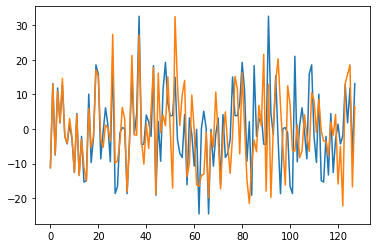

In [141]:
plot(X3[0].real)
plot(X2[0].real)